**"Bayesian adaptive prior, is that you?": Comparing different approaches of mixed effects modeling**

For a while, I've wondered about the different approches for multilevel modeling, also known as mixed effects modeling. I have a Bayesian perspective as my understanding since I learned about it first from Statistical Rethinking. But when hearing others talk about "fixed effects", "varying effects", and "mixed effects", I had trouble connecting my understanding of the concept to theirs. Even more perplexing, I wasn't sure what the *source(s)* of the differences were:
- It it a frequentist vs. Bayesian thing?
- Is it a statistical package thing?
- Is it because there are five different definitions of "fixed and random effects", [infamously observed by Andrew Gelman](https://statmodeling.stat.columbia.edu/2005/01/25/why_i_dont_use/) and why he avoids using those terms?

I decided to take a deep dive, with much help from numerous sources. Please check out the [Acknowledgments](#acknowledgements)!

In this post, I'll be comparing across statistical philosophies and across statistical languages. 


| method | approach  |  language | package |
| -- |-- | ------ | ----- |
| 1 | frequentist  |  R | `lme4` | 
| 2 | Bayesian  |  Python | `pymc` | 

In [7]:
from aesara import tensor as at   # needs to be fixed in repo
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc as pm
import xarray as xr

In [8]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

In [5]:
# Enable running of R code
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
%%R
suppressMessages(library(tidyverse))
suppressMessages(library(lme4))
suppressMessages(library(arm))
suppressMessages(library(merTools))

# Create synthetic `cafe` dataset.

Here's a brief description of the dataset from McElreath's book:
> Begin by defining the population of cafés that the robot might visit. This means we’ll define the average wait time in the morning and the afternoon, as well as the correlation between them. These numbers are sufficient to define the average properties of the cafés. Let’s define these properties, then we’ll sample cafés from them.

Nearly all Python code is taken from the [Statistical Rethinking pymc repo](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb) some minor alterations.

In [9]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

Mu = [a, b]

sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])
Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)  # covariance matrix

N_cafes = 20
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

Now simulate the observations.

In [10]:
N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
df_cafes = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

To get a more concrete sense of the data structure we just created, let's take a look at a few rows. We'll look at the first 5 rows, the last 5 rows, and a random sample of rows.

In [11]:
df_cafes.head()

,cafe,afternoon,wait
0,0,0,3.101138
1,0,1,2.615758
2,0,0,2.604023
3,0,1,2.140369
4,0,0,3.903201


In [12]:
df_cafes.tail()

,cafe,afternoon,wait
195,19,1,1.832679
196,19,0,2.547457
197,19,1,2.330300
198,19,0,2.511278
199,19,1,1.687872


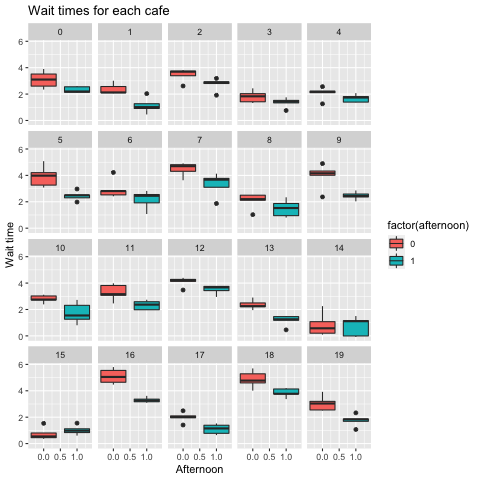

In [13]:
%%R -i df_cafes

# credit to TJ Mahr for a template of this code
xlab <- "Afternoon"
ylab <- "Wait time"
titlelab <- "Wait times for each cafe"

# order by increasing intercept?

ggplot(df_cafes) + 
  aes(x = afternoon, y = wait) + 
  geom_boxplot(aes(fill=factor(afternoon))) +
  facet_wrap("cafe") +
  #scale_x_discrete(c(0,1)) +
  labs(x = xlab, y = ylab, title=titlelab)

Now that we have the dataset, we can run the two models, one with `lmer` and one with `pymc`. Here are the equations that these packages run.

**Equation form 1: both fixed and varying effects terms in linear model**

[Galecki and Burzykowski](https://link.springer.com/book/10.1007/978-1-4614-3900-4) describe a linear mixed model with equation 1. Various sources (including [Wikipedia](https://en.wikipedia.org/wiki/Mixed_model)) have something similar. 

I'D LIKE TO RELATE EVERYTHING BACK TO THE CAFE EXAMPLE SO I'M GETTING CONFUSED WITH WHAT THE SUBSCRIPTS REPRESENT. IS "i" A SINGLE OBSERVATION AT A CAFE? OR IS IT THE CAFE ITSELF? IF THE LATTER, WHERE ARE SINGLE OBSERVATIONS REPRESENTED?

$$ \textbf{y}_i = \textbf{X}_i \boldsymbol{\beta} + \textbf{Z}_i \textbf{b}_i + \boldsymbol{\epsilon}_i  \tag{1}$$

I'M UNSURE ABOUT THESE NEXT FEW PARAGRAPHS.

The left side of the equation represents our observations (or the wait time in the cafe example). The $\boldsymbol{\beta}$ in the first term of the equation represents a vector of coefficients across the population of cafes. These are the fixed effects. The $\textbf{b}_i$ in the second term of equation 1 represents a vector of coefficients for *each individual cafe*. These are the random (or varying) effects. Both $\textbf{X}_i$ and $\textbf{Z}_i$ are the design matrix of covariates in a general sense but in this case they are both vectors. Specifically, in this example, the values are the same between both kinds of vectors (`afternoon`). Finally, there's a residual error term $\epsilon_i$ that is assumed to be normally distributed around 0. The role of the subscript "i" is to highlight how there are values for each observation.

The first two terms are written concisely in linear algebra form. Since we only have one covariate (`afternoon`), equation 1 can be written in an expanded, alternative form as equation 2. This might make it easier to understand (at least it did for me). The notation will start to get hairy with subscripts. I will explicitly rename some variables for this explanation. It will also better match with the Bayesian set of equations.
- Each individual element of the vector $\boldsymbol{\beta}$ (which one might call $\beta_0$ and $\beta_1$) will be called $\alpha$ and $\beta$. You can think of $\alpha$ and $\beta$ as a slope and intercept.
- $\textbf{y}_i$ will become $w_i$ (for wait time).
- The two vectors of covariates ($\textbf{X}_i$ and $\textbf{Z}_i$) will be represented by $A_i$.

$$ w_i = (\alpha + \beta \times A_i) + (\alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]} \times A_{\text{cafe}[i]}) + \epsilon_i \tag{2} $$

In this equation, I have segmented the fixed and random effects with parentheses. It might be easier to appreciate what's going on in equation 2. A cafe's random effects intercept can be thought of as an offset from the population intercept. The same logic of an offset can be applied to its slope.

**Equation form 2: fixed effects is represented as an adaptive prior, varying effects is in the linear model**

We can re-write the above equations in a Bayesian way but in this example I will write the equations where the fixed effects is shown as an adaptive prior. These set of equations look like a beast, but to be honest, they're more intuitive to me, probably because I learned this approach initially.

$$ w_i \sim \text{Normal}(\mu_i, \sigma) \tag{3} $$
$$ \mu_i = \alpha_{\text{cafe}[i]} + \beta_{\text{cafe}[i]} \times A_{i} \tag{4}$$
$$ \sigma \sim \text{Exp}(1) \tag{5}$$

Equation 3 is stating how wait time is normally distributed around $\mu$ and $\sigma$. By making $w_i$ stochastic instead of deterministic (using a ~ instead of =), the $\sigma$ replaces $\epsilon_i$. In equation 5, the prior for $\sigma$ is exponentially distributed and paramaterized with 1. The expected value parameter $\mu$ comes from the linear model in equation 4. You can see the similarities with equation 2 above. I think you can think of these $\alpha_i$ and $\beta_i$ terms as already incorporating the information from the fixed and random effects simultaneously.

$$ \begin{bmatrix}\alpha_j \\ \beta_j \end{bmatrix} \sim \text{MVNormal} \left( \begin{bmatrix}{\alpha} \\ {\beta} \end{bmatrix} , \textbf{S} \right)    \tag{5}$$

The $\alpha_i$ and $\beta_i$ terms come from sampling of a multivariate normal distribution as shown in equation 5. On the right side, the two-dimensional normal distribution's expected values are $\alpha$ and $\beta$.

$$ \textbf{S} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}  \tag{6}$$
$$ \bar{\alpha} \sim \text{Normal}(5, 2) \tag{7}$$  
$$ \bar{\beta} \sim \text{Normal}(-1, 0.5)  \tag{8}$$  
$$ \sigma, \sigma_{\alpha}, \sigma_{\beta} \sim \text{Exp}(1) \tag{9}$$
$$ \textbf{R} \sim \text{LKJCorr}(2) \tag{10}$$

In [ ]:
    # needs to be fixed in repo sd > sigma
    a_bar = pm.Normal("a_bar", mu=5, sigma=2.0)  # prior for average intercept
    b_bar = pm.Normal("b_bar", mu=-1, sigma=0.5)  # prior for average slope

# Visualize data

# Common definitions and examples of mixed effects modeling

The first equation has an explicit fixed effects term and varying effects term in the linear model (second line). The fixed and varying effects are the first and second parenthetical blocks, respectively.

In the second equation, the linear model is already "mixed". It contains both the fixed and varying effects terms implicitly. The fixed effects estimates can be seen in the third line.

In [14]:
df_cafes.head()

,cafe,afternoon,wait
0,0,0,3.101138
1,0,1,2.615758
2,0,0,2.604023
3,0,1,2.140369
4,0,0,3.903201


# Equation form 1 (frequentist)

The `lmer` and by extension (`brms`) syntax was confusing to me. Thanks to @probot from the Discord channel for helping me understand this.

`lmer(Reaction ~ 1 + Days + (1 + Days | Subject), df_cafes)`

The `1` corresponds to inclusion of the intercept term. A `0` would exclude it. The `1 + Days` corresponds to the "fixed effects" portion of the model ($\alpha + \beta \times d$) while the `(1 + Days | Subject)` is the "varying effects" ($\alpha_{[s]} + \beta_{[s]} \times d_{[s]}$).

In [15]:
%%R -i df_cafes -o m

m <- lmer(wait ~ 1 + afternoon + (1 + afternoon | cafe), df_cafes)
arm::display(m)

lmer(formula = wait ~ 1 + afternoon + (1 + afternoon | cafe), 
    data = df_cafes)
            coef.est coef.se
(Intercept)  2.97     0.27  
afternoon   -0.89     0.11  

Error terms:
 Groups   Name        Std.Dev. Corr  
 cafe     (Intercept) 1.19           
          afternoon   0.36     -0.90 
 Residual             0.54           
---
number of obs: 200, groups: cafe, 20
AIC = 415.7, DIC = 395.4
deviance = 399.6 


Can we get the partial pooling results from the `lmer` output and see how it compares with the unpooled estimates?

In [16]:
%%R -i m -o df_partial_pooling -o random_sims

# Make a dataframe with the fitted effects
df_partial_pooling <- coef(m)[["cafe"]] %>% 
  rownames_to_column("cafe") %>% 
  as_tibble() %>% 
  rename(Intercept = `(Intercept)`, Slope_Days = afternoon) %>% 
  add_column(Model = "Partial pooling")

# head(df_partial_pooling)
# coef(m)$cafe

# estimate confidence interval
random_sims <- REsim(m, n.sims = 1000)
#plotREsim(random_sims)

In [17]:
random_sims

,groupFctr,groupID,term,mean,median,sd
1,cafe,0,(Intercept),0.186344,0.196127,0.461593
2,cafe,1,(Intercept),-0.749693,-0.728833,0.488489
3,cafe,2,(Intercept),0.601278,0.607734,0.470783
4,cafe,3,(Intercept),-1.044545,-1.017750,0.489351
5,cafe,4,(Intercept),-0.784403,-0.795006,0.496605
6,cafe,5,(Intercept),0.807083,0.802478,0.491426
7,cafe,6,(Intercept),0.028451,0.013513,0.470069
8,cafe,7,(Intercept),1.507508,1.507308,0.494036
9,cafe,8,(Intercept),-0.843431,-0.822294,0.478616
10,cafe,9,(Intercept),0.819129,0.810831,0.480179


OK, now let's try the Bayesian approach and compare answers.

# Equation form 2 (Bayesian)

In [18]:
n_cafes = df_cafes['cafe'].nunique()
cafe_idx = pd.Categorical(df_cafes["cafe"]).codes

with pm.Model() as m14_1:
    # can't specify a separate sigma_a and sigma_b for sd_dist but they're equivalent here
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    # needs to be fixed in repo sd > sigma
    a_bar = pm.Normal("a_bar", mu=5, sigma=2.0)  # prior for average intercept
    b_bar = pm.Normal("b_bar", mu=-1, sigma=0.5)  # prior for average slope

    # needs to be fixed in repo tt.stack > at.stack
    ab_subject = pm.MvNormal(
        "ab_subject", mu=at.stack([a_bar, b_bar]), chol=chol, shape=(n_cafes, 2)
    )  # population of varying effects
    # shape needs to be (n_cafes, 2) because we're getting back both a and b for each cafe

    mu = ab_subject[cafe_idx, 0] + ab_subject[cafe_idx, 1] * df_cafes["afternoon"].values  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within cafes (in the top line)

    wait = pm.Normal("wait", mu=mu, sigma=sigma_within, observed=df_cafes["wait"].values)  # likelihood

    idata_m14_1 = pm.sample(1000, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, a_bar, b_bar, ab_subject, sigma_within]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [19]:
# take a glimpse at the head and tail of the summary table
pd.concat(
    [
        az.summary(idata_m14_1).head(10),
        az.summary(idata_m14_1).tail(10)
    ]
)

/Users/blacar/opt/anaconda3/envs/pymc_env2/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/blacar/opt/anaconda3/envs/pymc_env2/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,3.015,0.264,2.529,3.525,0.004,0.003,4623.0,3035.0,1.0
b_bar,-0.901,0.111,-1.112,-0.696,0.002,0.002,2674.0,2895.0,1.0
"ab_subject[0, 0]",3.136,0.209,2.721,3.507,0.003,0.002,4375.0,3129.0,1.0
"ab_subject[0, 1]",-0.873,0.220,-1.295,-0.446,0.003,0.002,4135.0,2781.0,1.0
"ab_subject[1, 0]",2.258,0.215,1.855,2.658,0.003,0.002,4703.0,3034.0,1.0
"ab_subject[1, 1]",-0.928,0.236,-1.386,-0.500,0.004,0.003,3247.0,2443.0,1.0
"ab_subject[2, 0]",3.515,0.216,3.101,3.904,0.003,0.002,4043.0,3136.0,1.0
"ab_subject[2, 1]",-0.891,0.226,-1.338,-0.482,0.004,0.003,3439.0,2846.0,1.0
"ab_subject[3, 0]",1.914,0.215,1.492,2.298,0.003,0.002,3978.0,2704.0,1.0
"ab_subject[3, 1]",-0.621,0.230,-1.047,-0.184,0.004,0.003,3266.0,3142.0,1.0


In [20]:
df_summary_int_and_slope = az.summary(idata_m14_1, var_names=['a_bar', 'b_bar'])
df_summary_int_and_slope

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,3.015,0.264,2.529,3.525,0.004,0.003,4623.0,3035.0,1.0
b_bar,-0.901,0.111,-1.112,-0.696,0.002,0.002,2674.0,2895.0,1.0


This compares well with the `lmer` output above.

```         
            coef.est coef.se
(Intercept)  2.97     0.27  
afternoon   -0.89     0.11  
```

Let's plot the varying effects between the two models too.

[Text(0.5, 0, 'lmer slope estimates'),
 Text(0, 0.5, 'pymc slope estimates'),
 Text(0.5, 1.0, 'Comparison of slopes')]

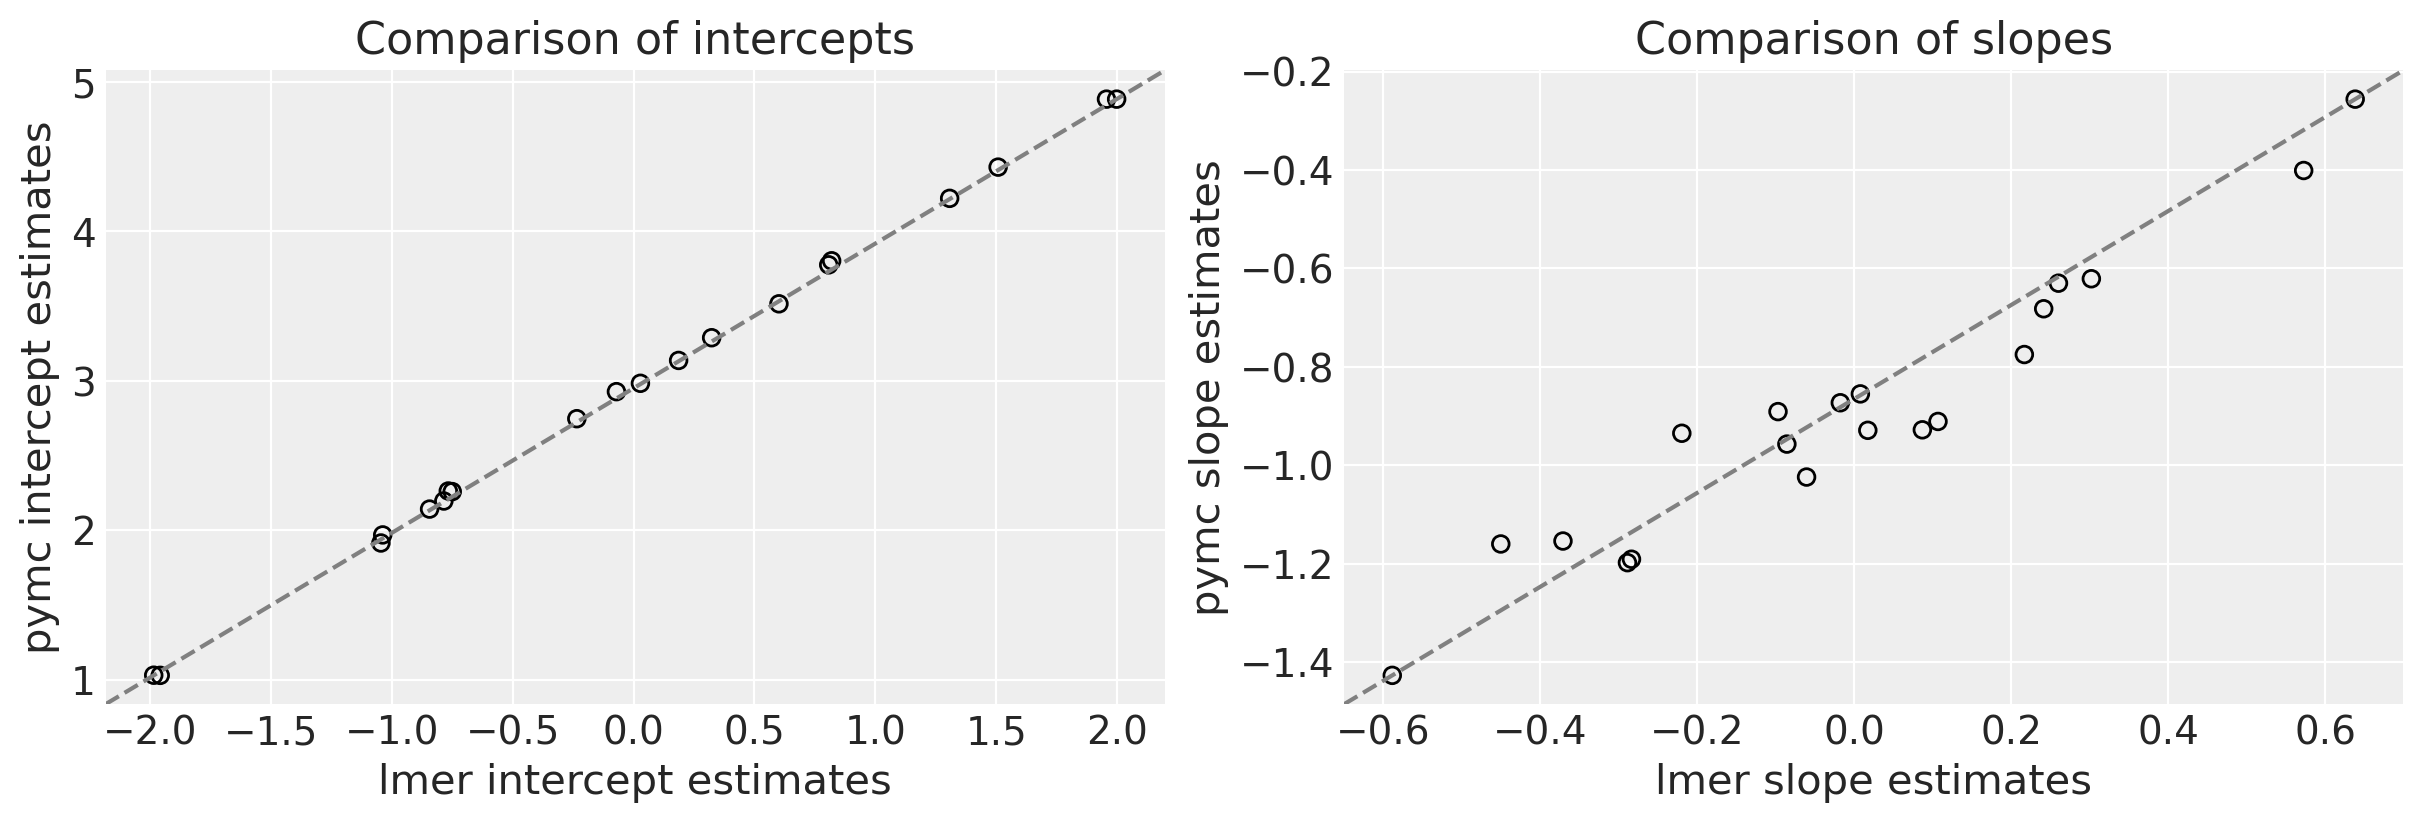

In [24]:
random_sims_int = random_sims.loc[random_sims['term']=='(Intercept)', 'mean'].copy()
random_sims_slope = random_sims.loc[random_sims['term']=='afternoon', 'mean'].copy()

df_summary_int_and_slope_cafes = az.summary(idata_m14_1, var_names=['ab_subject'])
bayesian_int = df_summary_int_and_slope_cafes.loc[df_summary_int_and_slope_cafes.index.str.contains(', 0\]'), 'mean']
bayesian_slope = df_summary_int_and_slope_cafes.loc[df_summary_int_and_slope_cafes.index.str.contains(', 1\]'), 'mean']

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
# intercepts
ax0.scatter(random_sims_int, bayesian_int, facecolors='none', edgecolors='black')
ax0.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle='dashed', color='gray')
ax0.set(xlabel='lmer intercept estimates', ylabel='pymc intercept estimates', title='Comparison of intercepts')

ax1.scatter(random_sims_slope, bayesian_slope, facecolors='none', edgecolors='black')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, linestyle='dashed', color='gray')
ax1.set(xlabel='lmer slope estimates', ylabel='pymc slope estimates', title='Comparison of slopes')

As you can see we get very similar intercepts and slopes for the cafe-specific estimates (varying effects) for the intercept and slope between the two approaches.

Here, I set out to compare different mixed model approaches. I looked at the equations and the programmatic implementations. I concluded by showing how the two methods arrive at the same answer.


NOTE TO SELF: Look at `pymc4.ipynb` for other ideas for plots.

# Acknowledgements

- Eric J. Daza about some discussions about mixed effects modeling. It reminded me about improving my knowledge in this area.
- Richard McElreath's Statistical Rethinking for my introduction to Bayesian multilevel modeling.
- Statistical Rethinking repo.
- Andrzej Gałecki and Tomasz Burzykowski's [Linear Mixed-Effecsts Models Using R](https://link.springer.com/book/10.1007/978-1-4614-3900-4) which references the `lme4` package. McElreath actually referenced this package as a non-Bayesian alternative in his book.
- Andrew Gelman wrote about why he doesn't like using "fixed and random effects" (in a [blog](https://statmodeling.stat.columbia.edu/2005/01/25/why_i_dont_use/) and in a [paper](https://projecteuclid.org/journals/annals-of-statistics/volume-33/issue-1/Analysis-of-variancewhy-it-is-more-important-than-ever/10.1214/009053604000001048.full)).
- TJ Mahr's [partial pooling blog post](https://www.tjmahr.com/plotting-partial-pooling-in-mixed-effects-models/).
- @probot from our Bayesian Discord channel.
- Thanks to the [`rpy2` package](https://rpy2.github.io/doc/latest/html/introduction.html) for allowing me to run R and Python code in the same notebook.

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl

Last updated: Tue Aug 23 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.3.0

aesara: 2.7.9
aeppl : 0.0.27

matplotlib: 3.5.1
aesara    : 2.7.9
pymc      : 4.0.0b6
numpy     : 1.22.4
xarray    : 0.20.1
pandas    : 1.4.2
sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:03:09) [Clang 13.0.1 ]
arviz     : 0.12.1

Watermark: 2.3.1



In [10]:
%%R
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Monterey 12.5

Matrix products: default
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] merTools_0.5.2  arm_1.12-2      MASS_7.3-57     lme4_1.1-30    
 [5] Matrix_1.4-1    forcats_0.5.2   stringr_1.4.1   dplyr_1.0.9    
 [9] purrr_0.3.4     readr_2.1.2     tidyr_1.2.0     tibble_3.1.8   
[13] ggplot2_3.3.6   tidyverse_1.3.2

loaded via a namespace (and not attached):
 [1] httr_1.4.4          jsonlite_1.8.0      splines_4.2.1      
 [4] foreach_1.5.2       modelr_0.1.9        shiny_1.7.2        
 [7] assertthat_0.2.1    broom.mixed_0.2.9.4 googlesheets4_1.0.1
[10] cellranger_1.1.0    globals_0.16.0      pillar_1.8.1       
[13] backports_1.4.1     lattice_0.20-45     glue_1.6.2         
[1